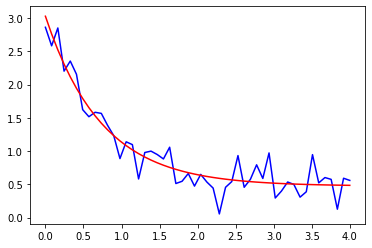

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',

         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

# FIT

In [8]:
def get_charge_model_fit(rho_host, rho_defect_q, host_structure):
    """
    Fit the charge model to the defect data

    Parameters
    ----------
    model_correction: orm.Float
        The correction energy derived from the electrostatic model
    total_alignment: orm.Float
        The correction energy derived from the alignment of the DFT difference
        potential and the model potential, and alignment of the defect potential
        in the q=0 charge state and the potential of the pristine host structure

    Returns
    -------
    total_correction
        The calculated correction, including potential alignment

    """

    from scipy.optimize import curve_fit
    #from .model_potential.utils import generate_charge_model, get_xyz_coords, get_cell_matrix

    # Get the cell matrix
    cell_matrix = get_cell_matrix(host_structure)

    # Compute the difference in charge density between the host and defect systems
    #rho_defect_q_data = rho_defect_q.get_array(rho_defect_q.get_arraynames()[0])
    #rho_host_data = rho_host.get_array(rho_host.get_arraynames()[0])

    rho_defect_q_data = rho_defect_q.read_grid().grid
    rho_host_data = rho_host.read_grid().grid

    # Charge density from QE is in e/cubic-bohr, so convert if necessary
    # TODO: Check if the CUBE file format is strictly Bohr or if this is a QE thing
    #rho_diff = (rho_host_data - rho_defect_q_data)/(bohr_to_ang**3)
    #rho_diff = rho_host_data - rho_defect_q_data
    rho_diff = rho_host_data - rho_defect_q_data

    # Detect the centre of the charge in the data
    max_pos_mat = np.array(np.unravel_index(rho_diff.argmax(), rho_diff.shape)) # matrix coords
    max_pos_ijk = (max_pos_mat*1.)/(np.array(rho_diff.shape)-1) # Compute crystal coords
    max_i = max_pos_ijk[0]
    max_j = max_pos_ijk[1]
    max_k = max_pos_ijk[2]

    # Generate cartesian coordinates for a grid of the same size as the charge data
    xyz_coords = get_xyz_coords(cell_matrix, rho_diff.shape)

    # Set up some safe parameters for the fitting
    guesses = [max_i, max_j, max_k, 1., 1., 1., 0., 0., 0.]
    bounds = (
        [0., 0., 0., 0., 0., 0., 0., 0., 0.,],
        [1., 1., 1., np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    peak_charge = rho_diff.max()
    fit, covar_fit = curve_fit(
        generate_charge_model(cell_matrix, peak_charge),
        xyz_coords,
        rho_diff.ravel(),
        p0=guesses,
        bounds=bounds)

    # Compute the one standard deviation errors from the 9x9 covariance array
    fit_error = np.sqrt(np.diag(covar_fit))

    fitting_results = {}

    fitting_results['fit'] = fit.tolist()
    fitting_results['peak_charge'] = peak_charge
    fitting_results['error'] = fit_error.tolist()

    return fitting_results #orm.Dict(dict=fitting_results)

def get_cell_matrix(structure):
    """
    Get the cell matrix (in bohr) from an AiiDA StructureData object

    Parameters
    ----------
    structure: AiiDA StructureData
        The structure object of interest

    Returns
    -------
    cell_matrix
        3x3 cell matrix array in units of Bohr

    """
    #cell_matrix = np.array(structure.cell) / bohr_to_ang  # Angstrom to Bohr
    cell_matrix = structure.cell
    return cell_matrix

def get_xyz_coords(cell_matrix, dimensions):
    """
    For a given array, generate an array of xyz coordinates in the cartesian basis
    """

    # Generate a grid of crystal coordinates
    i = np.linspace(0., 1., dimensions[0])
    j = np.linspace(0., 1., dimensions[1])
    k = np.linspace(0., 1., dimensions[2])
    # Generate NxN arrays of crystal coords
    iii, jjj, kkk = np.meshgrid(i, j, k, indexing='ij')
    # Flatten this to a 3xNN array
    ijk_array = np.array([iii.ravel(), jjj.ravel(), kkk.ravel()])
    # Change the crystal basis to a cartesian basis
    xyz_array = np.dot(cell_matrix.T, ijk_array)

    return xyz_array



In [11]:

def generate_charge_model(cell_matrix, peak_charge):
    """
    Return a function to compute a periodic gaussian on a grid.
    The returned function can be used for fitting. 

    Parameters
    ----------
    cell_matrix: 3x3 array
        Cell matrix of the real space cell
    peak_charge: float
        The peak charge density at the centre of the gaussian.
        Used for scaling the result.

    Returns
    -------
    compute_charge
        A function that will compute a periodic gaussian on a grid 
        for a given cell and peak charge intensity
    """

    def compute_charge(
        xyz_real,
        x0, y0, z0,
        sigma_x, sigma_y, sigma_z,
        cov_xy, cov_xz, cov_yz):
        """
        For a given system charge, create a model charge distribution using 
        an anisotropic periodic 3D gaussian.
        The charge model for now is a Gaussian.

        NOTE: 
        The values for sigma and cov are not the values used in construction 
        of the Gaussian. After the covariance matrix is constructed, its 
        transpose is multiplied by itself (that is to construct a Gram matrix) 
        to ensure that it is positive-semidefinite. It is this matrix which is 
        the real covariance matrix. This transformation is to allow this 
        function to be used directly by the fitting algorithm without a danger 
        of crashing.  

        Parameters
        ----------
        xyz_real: 3xN array 
            Coordinates to compute the Gaussian for in cartesian coordinates.
        x0, y0, z0: float
            Center of the Gaussian in crystal coordinates.
        sigma_x, sigma_y, sigma_z: float
            Spread of the Gaussian (not the real values used, see note above).
        cov_xy, cov_xz, cov_yz: float
            Covariance values controlling the rotation of the Gaussian 
            (not the real values used, see note above).

        Returns
        -------
        Returns
        -------
        g
            Values of the Gaussian computed at all of the desired coordinates and 
            scaled by the value of charge_integral.

        """

        # Construct the pseudo-covariance matrix
        V = np.array([[sigma_x, cov_xy, cov_xz],[cov_xy, sigma_y, cov_yz], [cov_xz, cov_yz, sigma_z]])
        # Construct the actual covariance matrix in a way that is always positive semi-definite
        # Construct the actual covariance matrix in a way that is always positive semi-definite
        covar = np.dot(V.T, V)

        gauss_position = np.array([x0, y0, z0])

        # Apply periodic boundary conditions
        g = 0
        for ii in [-1, 0, 1]:
            for jj in [-1, 0, 1]:
                for kk in [-1, 0, 1]:
                    # Compute the periodic origin in crystal coordinates
                    origin_crystal = (gauss_position + np.array([ii, jj, kk])).reshape(3,1)
                    # Convert this to cartesian coordinates
                    origin_real = np.dot(cell_matrix.T, origin_crystal)
                    # Compute the Gaussian centred at this position
                    g = g + get_gaussian_3d(xyz_real.T, origin_real, covar)


        print("DEBUG: Integrated charge density (unscaled) = {}".format(get_integral(g, cell_matrix)))

        print("DEBUG: g.max()  = {}".format(g.max()))
        # Scale the result to match the peak charge density
        g = g * (peak_charge / g.max())
        print("DEBUG: Peak Charge target  = {}".format(peak_charge))
        print("DEBUG: Peak Charge scaled  = {}".format(g.max()))
        print("DEBUG: Integrated charge density (scaled) = {}".format(get_integral(g, cell_matrix)))

        return g

    return compute_charge


In [14]:
def get_gaussian_3d(grid, origin, covar):
    """
    Compute anisotropic 3D Gaussian on grid

    Parameters
    ----------
    grid: array
        Array on which to compute gaussian
    origin: array
        Centre of gaussian
    covar: 3x3 array 
        Covariance matrix of gaussian
        
    Returns
    -------
    gaussian
        anisotropic Gaussian on grid
    """

    from scipy.stats import multivariate_normal

    origin = origin.ravel()
    gaussian = multivariate_normal.pdf(grid, origin, covar)

    return gaussian

In [17]:
def get_integral(data, cell_matrix):
    """
    Get the integral of a uniformly spaced 3D data array by rectangular rule.
    Works better than trapezoidal or Simpson's rule for sharpely peaked coarse grids.
    """
    a = cell_matrix[0]
    b = cell_matrix[1]
    c = cell_matrix[2]
    cell_vol = np.dot(np.cross(a, b), c)
    element_volume = cell_vol / np.prod(data.shape)
    return np.sum(data) * element_volume


In [18]:
from SiestaDefects.Utils import utils_defects as utils
GaAs_222_dir = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222/GaAs-222-cg-0-6293038.frontal2/'
GaAs_222_GaV_0e_dir_cg0 = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV/GaAs-222-VGa-cg-0-6435564.frontal2/'
GaAs_222_GaV_0e_dir_relax = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV/GaAs-222-VGa-relax-6436782.frontal2/'

GaAs_222_GaV_1e_dir_cg0 = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e1/GaAs-222-VGa-1e-cg-0-6293054.frontal2/'
GaAs_222_GaV_1e_dir_relax = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e1/GaAs-222-VGa-1e-relax-6435606.frontal2/'
GaAs_222_GaV_2e_dir_cg0 = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e2/GaAs-222-VGa-2e-cg-0-6293055.frontal2/'
GaAs_222_GaV_2e_dir_relax = '/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e2/GaAs-222-VGa-2e-relax-6435670.frontal2/'
GaAs_222_GaV_3e_dir_cg0 ='/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e3/GaAs-222-VGa-3e-cg-0-6293057.frontal2/'
GaAs_222_GaV_3e_dir_relax ='/home/aakhtar/Calculations/2020/siesta/Defects/GaAs/LDA-standard-New/222-GaV-e3/GaAs-222-VGa-3e-relax-6435673.frontal2/'
host = GaAs_222_dir
defect_neutral = GaAs_222_GaV_0e_dir_cg0
defect_charged = GaAs_222_GaV_3e_dir_cg0
#host = GaAs_333_dir
#defect_neutral = GaAs_333_GaV_0e_dir_cg0
#defect_charged = GaAs_333_GaV_2e_dir_cg0

#-------------------------------------------
host_fdf = utils.Read_FDF_File(host,'input')
defect_q0_fdf = utils.Read_FDF_File(defect_neutral,'input')
defect_q_fdf = utils.Read_FDF_File(defect_charged,'input')
#-------------------------------------------
host_geometry = host_fdf.read_geometry()
defect_q0_geometry = host_fdf.read_geometry()
defect_q_geometry = host_fdf.read_geometry()
#---------------------------------------------
host_VT = utils.Read_VT_File(GaAs_222_dir,'GaAs')
defect_q0_VT = utils.Read_VT_File(defect_neutral,'GaAs')
defect_q_VT = utils.Read_VT_File(defect_charged,'GaAs')
#---------------------------------------------
host_Rho = utils.Read_Rho_File(GaAs_222_dir,'GaAs')
defect_q0_Rho = utils.Read_Rho_File(defect_neutral,'GaAs')
defect_q_Rho = utils.Read_Rho_File(defect_charged,'GaAs')

In [20]:
import time
start_time = time.time()

fit = get_charge_model_fit(rho_host=host_Rho,
                           rho_defect_q=defect_q0_Rho,
                           host_structure=host_geometry)
print("--- %s min ---" % ((time.time() - start_time)/60.0))
print("--- %s seconds ---" % (time.time() - start_time))


DEBUG: Integrated charge density (unscaled) = 1.0574573656740125
DEBUG: g.max()  = 0.06349363593424098
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 106.65104075739963
DEBUG: Integrated charge density (unscaled) = 1.057457364873567
DEBUG: g.max()  = 0.06349363593424008
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 106.65104067667127
DEBUG: Integrated charge density (unscaled) = 1.0574573648735666
DEBUG: g.max()  = 0.06349363593424008
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 106.65104067667116
DEBUG: Integrated charge density (unscaled) = 1.0574573646210217
DEBUG: g.max()  = 0.06349363593424008
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge

DEBUG: Integrated charge density (unscaled) = 1.1631981822776178
DEBUG: g.max()  = 0.8434043184971493
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 8.831822317959615
DEBUG: Integrated charge density (unscaled) = 1.1631981814498267
DEBUG: g.max()  = 0.8434043506242752
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 8.83182197525091
DEBUG: Integrated charge density (unscaled) = 1.1631981852414748
DEBUG: g.max()  = 0.8434043066540201
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 8.83182246448024
DEBUG: Integrated charge density (unscaled) = 1.1631981852899382
DEBUG: g.max()  = 0.8434043071243527
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density

DEBUG: Integrated charge density (unscaled) = 1.198242289273028
DEBUG: g.max()  = 1.2760865299760324
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.013079521297218
DEBUG: Integrated charge density (unscaled) = 1.198242289269379
DEBUG: g.max()  = 1.2760865299431214
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.013079521433981
DEBUG: Integrated charge density (unscaled) = 1.1982422892631668
DEBUG: g.max()  = 1.276086529898825
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.013079521611542
DEBUG: Integrated charge density (unscaled) = 1.1982422923257037
DEBUG: g.max()  = 1.2760865826855485
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density 

DEBUG: Integrated charge density (unscaled) = 1.1981867148050551
DEBUG: g.max()  = 1.275645950972486
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.014877318854262
DEBUG: Integrated charge density (unscaled) = 1.1981867146696363
DEBUG: g.max()  = 1.2756459489471366
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.014877327724316
DEBUG: Integrated charge density (unscaled) = 1.198186714680571
DEBUG: g.max()  = 1.2756458502465053
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.014877793168711
DEBUG: Integrated charge density (unscaled) = 1.19818671467743
DEBUG: g.max()  = 1.2756458502359436
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (

DEBUG: Integrated charge density (unscaled) = 1.1981996400098727
DEBUG: g.max()  = 1.2753827461221243
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016183526187169
DEBUG: Integrated charge density (unscaled) = 1.198199640035629
DEBUG: g.max()  = 1.2753827465094725
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016183524489309
DEBUG: Integrated charge density (unscaled) = 1.1981996399224526
DEBUG: g.max()  = 1.2753827447213852
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016183532355742
DEBUG: Integrated charge density (unscaled) = 1.1981996398917225
DEBUG: g.max()  = 1.2753827430909999
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge densit

DEBUG: Integrated charge density (unscaled) = 1.198198910606258
DEBUG: g.max()  = 1.2753727642274095
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.0162269503644525
DEBUG: Integrated charge density (unscaled) = 1.1981989104937436
DEBUG: g.max()  = 1.2753727625005205
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016226957945636
DEBUG: Integrated charge density (unscaled) = 1.1981989104639446
DEBUG: g.max()  = 1.2753726632292703
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016227426081402
DEBUG: Integrated charge density (unscaled) = 1.1981989104612625
DEBUG: g.max()  = 1.275372663220534
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge densit

DEBUG: Integrated charge density (unscaled) = 1.1981989725896827
DEBUG: g.max()  = 1.275371809991334
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016231762941711
DEBUG: Integrated charge density (unscaled) = 1.1981989696287543
DEBUG: g.max()  = 1.2753717948349006
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.016231819571206
DEBUG: Integrated charge density (unscaled) = 1.198198969654314
DEBUG: g.max()  = 1.2753717954278285
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (scaled) = 6.01623181690256
DEBUG: Integrated charge density (unscaled) = 1.198198969541887
DEBUG: g.max()  = 1.2753717937020288
DEBUG: Peak Charge target  = 6.403721392154694
DEBUG: Peak Charge scaled  = 6.403721392154694
DEBUG: Integrated charge density (

In [ ]:
generate_charge_model(cell_matrix, peak_charge)

# Plot

In [10]:



%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



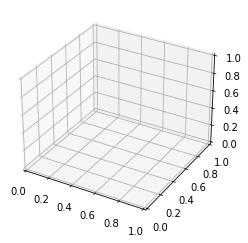

In [11]:


fig = plt.figure()
ax = plt.axes(projection='3d')



In [12]:


def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)



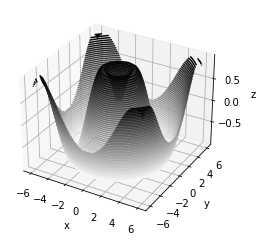

In [13]:


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');



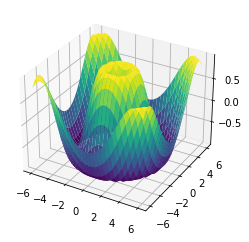

In [15]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')